# Open Market Backtesting

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Setting up the data

In [2]:
daily = False
datapath='../data/'
backtest_start_year = 2000

if daily:
    d = 3000
    start_date_a_estimation='2013-01-01'
    end_date_a_estimation=str(backtest_start_year)+'-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date_a_estimation='1965-01-01'
    end_date_a_estimation=str(backtest_start_year)+'-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df_a_estimation = Data(d=d, start_date=start_date_a_estimation, end_date=end_date_a_estimation, datapath=datapath, 
                       filename=filename, caps_table=caps_table, returns_table=returns_table)
df_backtest = Data(d=d, start_date=start_date_backtest, end_date=end_date_backtest, datapath=datapath, filename=filename, 
                   caps_table=caps_table, returns_table=returns_table)

### Estimating $a$ and Computing Optimal Strategy

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


[-1.11475639 -1.11259474 -1.11043728 -1.108284   -1.10613489]


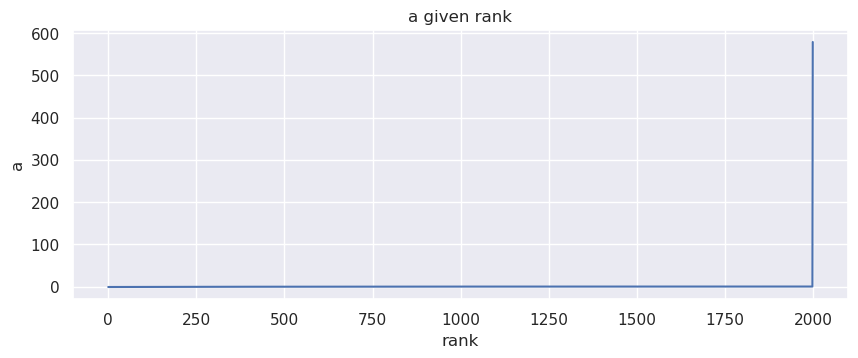

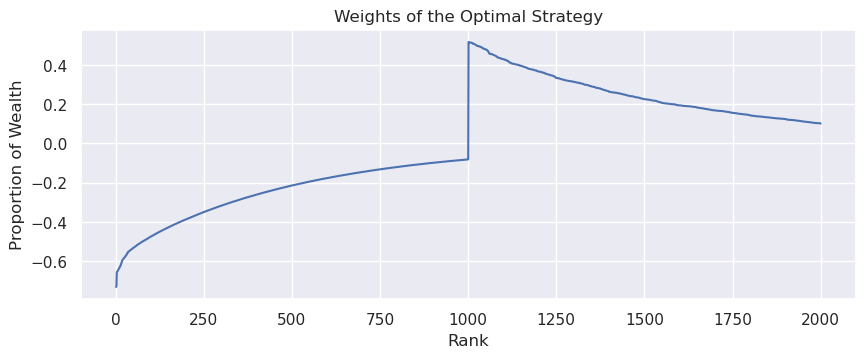

In [3]:
# Estimate a
method = 'direct_log'
smooth_method = 'exponential_decay'
smooth_parameter = 1
smooth_a = False

a = estimate_a(df_a_estimation.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
print(a[:5])
plot_a(a[:])

# Compute Strategy
setting = 'mixed'
N = 1000
plot_date = '2013-03-28'

strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df_backtest.weights_by_rank)
plot_strategy(strategy, plot_date)

### Robust Optimal Growth

The Robust Optimal Growth of the Optimal Strategy in the Pure Open Market setting is given by

$$
\hat \lambda _o = \mathbb E^{\beta} \left [ \frac 1 T \log V_T \right] = \frac 1 2 (1-\bar a_1) + \frac 1 8 \int_{\nabla^{d-1}} \left ( \sum_{k=1}^N \frac{a_k^2}{y_k} - \frac{(\bar a_1^N-2)^2}{\bar y_1^N} \right) q(y) dy 
$$

The Robust Optimal Growth Rate in the Mixed Open Market setting is given by

$$
\hat \lambda _o = \mathbb E^{\beta} \left [ \frac 1 T \log V_T \right] = \frac 1 8 (\bar a_1)^2 + \frac 1 8 \int_{\nabla^{d-1}} \left ( \sum_{k=1}^N \frac{a_k^2}{y_k} + \frac{(\bar a_{N+1})^2}{\bar y_{N+1}} \right) q(y) dy  = 
 \frac 1 8 (\bar a_1)^2  + \frac 1 8 \sum_{k=1}^N a_k^2 \int_{\nabla^{d-1}} \frac{1}{y_k} q(y) dy + \frac 1 8 (\bar a_{N+1})^2 \int_{\nabla^{d-1}}  \frac{1}{\bar y_1^N} q(y) dy
$$

In the Open Market case we just have
$$
\hat \lambda _o =  \frac 1 2 (1-\bar a_1)  + \frac 1 8 \sum_{k=1}^N a_k^2 \int_{\nabla^{d-1}} \frac{1}{y_k} q(y) dy - \frac 1 8 (\bar a_1^N-2)^2 \int_{\nabla^{d-1}}  \frac{1}{\bar y_1^N} q(y) dy

$$
So we need to estimate 
$$
\int_{\nabla^{d-1}} \frac{1}{y_k} q(y) dy \quad \text{ and } \quad \int_{\nabla^{d-1}}   \frac{1}{\bar y_1^N}  q(y) dy
$$


From Proposition 4 in https://arxiv.org/pdf/2302.13707.pdf we know that if we have $\bar a_1=0$ we have that the log gaps $Z_k = \log Y_{k-1} - \log Y_k$ are independent and satisfy
$$
Z_k \sim \exp(\bar a_k), \quad \forall k \in \{2,\dots, d\}
$$

If we define $E_1 := 1 $ and $E_k := \exp (-(Z_2 + \dots Z_k)) \quad \forall k \in \{2, \dots, d\}$ we can write (see calculations page 27.2 and 28.2):

$$
Y_d = \frac{E_d}{\sum_{i=1}^d E_i}, \quad Y_k = \frac{E_k}{\sum_{i=1}^k E_i} (1- \bar Y_{k+1}), \quad \forall k \in \{2,\dots, d\}
$$

From this relation we can now sample $Z_k$, which allows to sample $E_k$ which thus allows us to sample $Y_k$.

In [80]:
smooth_method = 'exponential_decay'
smooth_parameter = 1

a_bar = compute_a_bar_direct_log(weights_by_rank_df=df_a_estimation.weights_by_rank)
# a_bar = smooth_time_series(a_bar, smooth_method=smooth_method, smooth_parameter=smooth_parameter)
a_bar

array([  0.        ,   4.47870698,   3.66295098, ..., 435.97574586,
       493.82117047, 457.21127253])

Sampled Y sums up to 1.0000000000000013
First Components of Y [0.0435052  0.02913479 0.01857823 0.01717334 0.01690911]


0.0

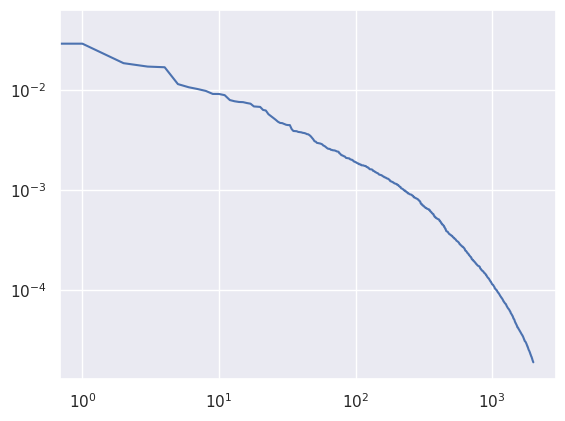

In [81]:
def sample_z(a_bar):
    d = len(a_bar)
    z = np.zeros(d)
    for k in range(1, d):  # z_1 is not used, so we start from 1
        z[k] = np.random.exponential(1/a_bar[k])
    return z

def compute_e(z):
    d = len(z)
    e = np.zeros(d)
    e[0] = 1  # E_1 is defined as 1
    for k in range(1, d):
        e[k] = np.exp(-np.sum(z[1:k+1]))
    return e

def sample_y(e):
    d = len(e)
    y = np.zeros(d)
    y[d-1] = e[d-1] / np.sum(e)  # Start by calculating y_d based on your formula

    for k in range(d-2, -1, -1):  # Go backwards from d-2 to 0
        y_bar = np.sum(y[k+1:])  # Calculate \bar y_k
        y[k] = (e[k] / np.sum(e[:k+1])) * (1 - y_bar)

    return y

def sample_Y(a_bar):
    z_sample = sample_z(a_bar)
    e_sample = compute_e(z_sample)
    y_sample = sample_y(e_sample)
    return y_sample

y = sample_Y(a_bar)
print('Sampled Y sums up to', sum(y))
print('First Components of Y', y[:5])
plt.loglog(y)
a_bar[0]

In [82]:
def estimate_E_inv_Y_k(a_bar, N, num_simulations=10000):
    sum_reciprocal_Y_k = np.zeros(N)

    for _ in range(num_simulations):
        y_sample = sample_Y(a_bar)
        sum_reciprocal_Y_k += 1.0 / y_sample[:N]

    return sum_reciprocal_Y_k / num_simulations

def estimate_E_inv_tail_Y(a_bar, N, num_simulations=10000):
    sum_reciprocal_tail_Y = 0.0

    for _ in range(num_simulations):
        y_sample = sample_Y(a_bar)
        tail_Y = np.sum(y_sample[N-1:])  # Compute the tail sum from Y_N to Y_d
        sum_reciprocal_tail_Y += 1.0 / tail_Y

    return sum_reciprocal_tail_Y / num_simulations



E_inv_Y = estimate_E_inv_Y_k(a_bar=a_bar, N=N, num_simulations=10)
E_inv_tail_Y = estimate_E_inv_tail_Y(a_bar=a_bar, N=N, num_simulations=10)
print('E Inverse of Y_k:', E_inv_Y[:5])
print('E Inverse of Tail Y:', E_inv_tail_Y)

E Inverse of Y_k: [31.96385474 36.88614285 42.09038049 54.9081482  61.41157161]
E Inverse of Tail Y: 19.4620513490574


In [83]:
def compute_growth_rate_pure_open(a, a_bar, integrals_y, integral_tail_y):
    N = len(integrals_y)
    term1 = 0.5 * (1 - a_bar[0])
    term2 = 0.125 * np.sum(a[:N]**2 * integrals_y)
    term3 = 0.125 * (np.sum(a[:N]) - 2)**2 * integral_tail_y

    lambda_hat = term1 + term2 - term3
    return lambda_hat

def compute_growth_rate_mixed_open(a, a_bar, integrals_y, integral_tail_y):
    N = len(integrals_y)
    term1 = 0.125 * (a_bar[0])**2
    term2 = 0.125 * np.sum(a[:N]**2 * integrals_y)
    term3 = 0.125 * (np.sum(a[N:]))**2 * integral_tail_y

    lambda_hat = term1 + term2 + term3
    return lambda_hat


In [88]:
print(sum(a[:N]))
print(a_bar[0]-a_bar[N+1])

-492.34683294556726
-492.5068661514527


In [87]:
method = 'direct_log'
smooth_method = 'exponential_decay'
smooth_parameter = 1
smooth_a = False
N=1000

a = estimate_a(df_a_estimation.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
a_bar = compute_a_bar_direct_log(weights_by_rank_df=df_a_estimation.weights_by_rank)
a_bar = smooth_time_series(a_bar, smooth_method=smooth_method, smooth_parameter=smooth_parameter)
E_inv_Y = estimate_E_inv_Y_k(a_bar=a_bar, N=N, num_simulations=100)
E_inv_tail_Y = estimate_E_inv_tail_Y(a_bar=a_bar, N=N, num_simulations=100)

robust_growth_pure = compute_growth_rate_pure_open(a, a_bar, E_inv_Y, E_inv_tail_Y)
robust_growth_mixed = compute_growth_rate_mixed_open(a, a_bar, E_inv_Y, E_inv_tail_Y)

print('Robust Growth Pure Open Market:', round(robust_growth_pure, 3))
print('Robust Growth Mixed Open Market:', round(robust_growth_mixed, 3)) 

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


Robust Growth Pure Open Market: -473809.825
Robust Growth Mixed Open Market: 600164.919
